# Lid-Driven Cavity

This tutorial implements the classic lid-driven cavity set-up.
The domain is a square box with four walls.
The top wall is moving with a prescribed velocity to the right.
This will accelerate a swirl inside the box. depending on the wall velocity
the velocity contours can be compared with experimental investigations.

/usr/local/lib/python3.8/dist-packages/scipy/sparse/linalg/_dsolve/linsolve.py:230: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)
/home/fynne/odin/pythonPlayground/src/MultiphaseTestBench/PressureModels.py:113: RuntimeWarning: divide by zero encountered in divide
  self.d_v = faceAreas_v/centreCoeffs_v


pcorr norm:  nan
pcorr norm:  nan
pcorr norm:  nan
pcorr norm:  nan
pcorr norm:  nan


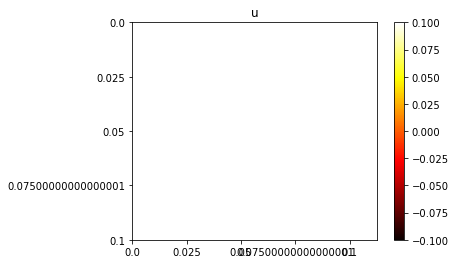

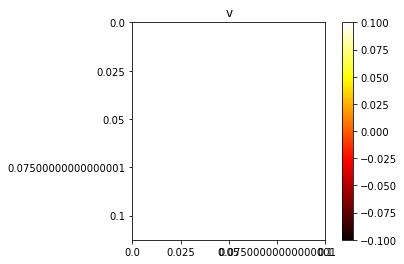

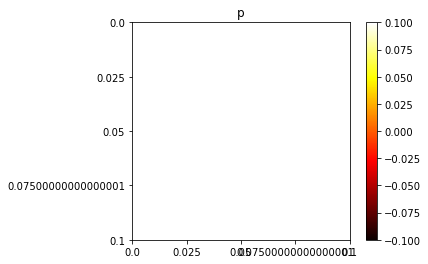

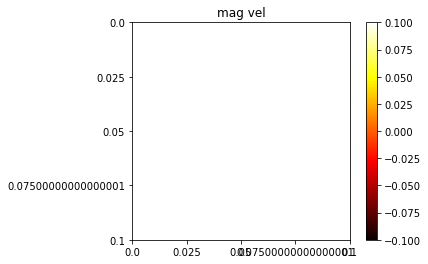

In [1]:
%reset -f
%load_ext autoreload
%autoreload 2

#SMALL = 1e-10

import Manager as Odin
from fieldAccess import *
import numpy as np
import Differentiation

geom = Odin.createGeometry( 'rectangle', [0.1,0.1] )
mesh = Odin.createMesh( geom, res=80 )

movingWallVelocity = 0.01

myFlowModels = {
    'u' : Odin.TransportModels.staggeredTransport_u,
    'v' : Odin.TransportModels.staggeredTransport_v,
    'p' : Odin.PressureModels.Pressure
}
closure = {
    'u' : ['v','p'],
    'v' : ['u','p'],
    'p' : ['u','v'],
}

Odin.initialize(flowmodels=myFlowModels, mesh=mesh, geometry=geom,closure = closure, passiveFields={} )

u=Odin.getField('u')
v=Odin.getField('v')
p=Odin.getField('p')

# relates to viscosity:
u.govModel.setDiffusionCoefficient(1)
v.govModel.setDiffusionCoefficient(1)

u.data.fill(0.0)
#u.data = SMALL*np.random.rand(*u.data.shape)
Odin.defineBoundaryCondition(field=u, boundaryName='top', type='fixedValue', value=movingWallVelocity)
Odin.defineBoundaryCondition(field=u, boundaryName='bottom', type='fixedValue', value=0 )
Odin.defineBoundaryCondition(field=u, boundaryName='right', type='fixedValue', value=0 )
Odin.defineBoundaryCondition(field=u, boundaryName='left', type='fixedValue', value=0)

v.data.fill(0.0)
#v.data = SMALL*np.random.rand(*v.data.shape)
Odin.defineBoundaryCondition(field=v, boundaryName='top', type='fixedValue', value=0)
Odin.defineBoundaryCondition(field=v, boundaryName='bottom', type='fixedValue', value=0)
Odin.defineBoundaryCondition(field=v, boundaryName='left', type='fixedValue', value=0 )
Odin.defineBoundaryCondition(field=v, boundaryName='right', type='fixedValue', value=0)

# constantPressure or freeFlow
boundaryType = 'constantPressure'
p.data.fill(0.0)
#p.data = SMALL*np.random.rand(*p.data.shape)
Odin.defineBoundaryCondition(field=p, boundaryName='top', type=boundaryType, value=0)
Odin.defineBoundaryCondition(field=p, boundaryName='bottom', type=boundaryType, value=0)
Odin.defineBoundaryCondition(field=p, boundaryName='left', type=boundaryType , value=0)
Odin.defineBoundaryCondition(field=p, boundaryName='right', type=boundaryType, value=0)

alphaP = 0.1
alphaV = 0.4

for i in range(5):
#    print(i)

    u.data = Odin.solve(u)
    v.data = Odin.solve(v)

    # pressure correction
    pcorr = Odin.solve(p)
    print("pcorr norm: ", np.linalg.norm(pcorr)/mesh.nbCells)
#    Odin.display(p_correction,mesh, 'pcorr')

    p.data +=  alphaP*pcorr

    # ucorr = -Differentiation.grad_u(pcorr, mesh)/u.govModel.a_p[internal_u]
    # vcorr = -Differentiation.grad_v(pcorr, mesh)/v.govModel.a_p[internal_v]
    #
    # u.data[internal_u] += ucorr
    # v.data[internal_v] += vcorr

    u.data[internal_u] =  alphaV*p.govModel.d_u[internal_u] * ( pcorr[west]- pcorr[east] )
    v.data[internal_v] =  alphaV*p.govModel.d_v[internal_v] * ( pcorr[south]- pcorr[north])


#
# for i in range(10):
#     # u_old = np.copy(u.data)
#     # v_old = np.copy(v.data)
#
#     u.data = Odin.solve(u)
#     v.data = Odin.solve(v)
#
#     p_correction = Odin.solve(p)
#     p.data +=  alphaP*p_correction
#
#     u.data[internal_u] += alphaV*(p.govModel.d_u[internal_u] * ( p_correction[west]- p_correction[east] ))
#     v.data[internal_v] += alphaV*(p.govModel.d_v[internal_v] * ( p_correction[south]- p_correction[north] ))
#
#     # u.data[internal_u] = alphaV*u_new + (1.0-alphaV)*u_old[internal_u]
#     # v.data[internal_v] = alphaV*v_new + (1.0-alphaV)*v_old[internal_v]
#     #
#     # u.data[internal_u] +=  p.govModel.d_u[internal_u] * ( p_correction[west]- p_correction[east] )
#     # v.data[internal_v] += p.govModel.d_v[internal_v] * ( p_correction[south]- p_correction[north])
#     #
#     # u_new = u.data[internal_u] + p.govModel.d_u[internal_u] * ( p_correction[west]- p_correction[east] )
#

Odin.display(u,mesh, 'u')
Odin.display(v,mesh, 'v')
Odin.display(p,mesh, 'p')


vel = Odin.calcCollocatedVelocityField(u.data, v.data)
velMag = Odin.calcVelocityMagnitude(vel)
Odin.display(velMag,mesh, 'mag vel')


In [ ]:
# shutting the interpreter down, so I can a fresh instance next time.
# my modules are automatically checked for updates
import os
os._exit(00)